#**PIPELINE**

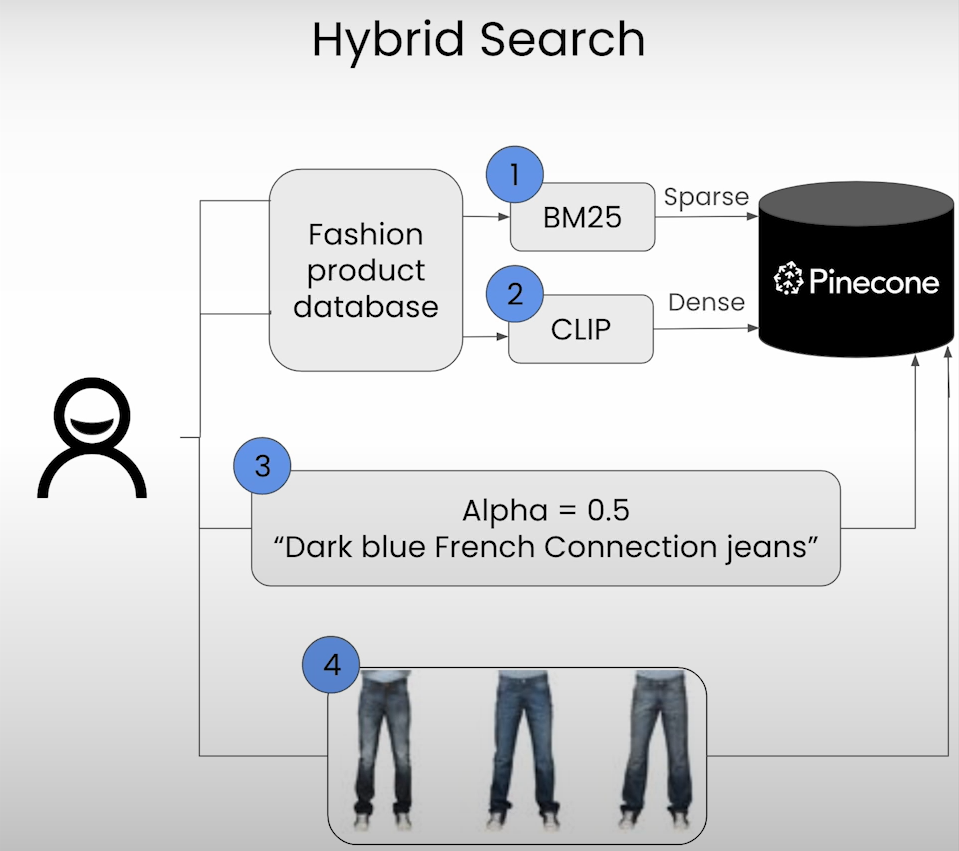

#**required packages**

In [1]:
!pip install --upgrade --quiet  pinecone-client pinecone-text pinecone-notebooks langchain_community langchain_huggingface datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from pinecone import Pinecone, ServerlessSpec
from pinecone_text.sparse import BM25Encoder
from tqdm.auto import tqdm

import os
import torch

#**cuda**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#**Dataset**

In [4]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/867 [00:00<?, ?B/s]

(…)-00000-of-00002-6cff4c59f91661c3.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

(…)-00001-of-00002-bb459e5ac5f01e71.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [5]:
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

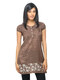

In [6]:
# taking image and store it in a variable
images = fashion['image']

#taking metadat without images
metadata = fashion.remove_columns('image')

# display a sample example of image
images[900]

In [7]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


#**pinecone setup**

##**api key**

In [8]:
api_key="pcsk_2Apmok_K7oQCdUi9qZ3RDPXh1XXPGjP9kH8zsEnBzvsVPCy3ofPoL1nBoT6WgBY1PSCxTs"


##**Create index**

In [9]:
INDEX_NAME = "hybrid-search-bm25-clip"

pinecone = Pinecone(api_key=api_key)

# checking for exisiting index
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)

# create index
pinecone.create_index(
  INDEX_NAME,
  dimension=512,
  metric="dotproduct", # sparse values supported only for dotproduct
  spec=ServerlessSpec(cloud='aws', region='us-east-1')
)

# create a pointer to index
index = pinecone.Index(INDEX_NAME)

#**Hybrid Search**

##**sparse search**

In [10]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# intialize the bm25
bm25 = BM25Encoder()
# sparse search on product name (keyword search)
bm25.fit(metadata['productDisplayName'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/44072 [00:00<?, ?it/s]

In [12]:
title = metadata['productDisplayName'][0]
title

'Turtle Check Men Navy Blue Shirt'

In [13]:
# encode the title as a query
bm25.encode_queries(title)


{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596145,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.14930395560085577]}

In [14]:
bm25.encode_documents(title)

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

##**Dense search**

##**CLIP**

##**CLIP (Contrastive Language–Image Pretraining)**

CLIP is a model developed by OpenAI that jointly encodes both images and text into a shared embedding space. This enables powerful multimodal search and retrieval tasks, such as hybrid search systems.

## Key Features

### Image Encoding
CLIP processes images using a vision model (e.g., Vision Transformer or ResNet) to extract dense feature representations.

### Text Encoding
CLIP processes text using a transformer-based language model to create corresponding dense embeddings.

### Shared Space
Both image and text encoders map their respective inputs into the same feature space. This shared space enables direct comparisons between image and text embeddings, allowing CLIP to support multimodal search and retrieval.

## How CLIP Knows the Text
CLIP doesn’t explicitly "know" the text associated with an image unless it is provided as input. In hybrid search scenarios:

1. **Image Data**: CLIP generates dense embeddings from the input images using the vision model.
2. **Textual Metadata**: Text inputs, such as concatenated metadata fields, are processed by the text encoder to produce embeddings.

Both types of embeddings are stored in the shared space and can be queried or combined for hybrid search tasks.

## Use Case: Hybrid Search with Pinecone
- **Dense Embeddings**: CLIP is used to encode both images and textual metadata into dense vectors.
- **Sparse Embeddings**: Methods like BM25 encode textual metadata into sparse vectors.
- **Indexing**: A hybrid search index combines sparse and dense embeddings for efficient and accurate retrieval.

This approach enables systems to leverage the strengths of both sparse and dense representations for better search performance.


In [15]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32',
    device=device)
model

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)

In [16]:
# dense retrieval based on product name
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

In [17]:
len(fashion)

44072

##**Create Embeddings Using Sparse and Dense**


In [18]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [19]:
index.describe_index_stats()

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

#**Test queries**

In [21]:
query = "dark blue french connection jeans for men"

# sparse encode for keyword search
sparse = bm25.encode_queries(query)
# dense encode for image/text retrieval
dense = model.encode(query)
dense_list = model.encode(query).tolist()


result = index.query(
    top_k=14,
    vector=dense_list,
    sparse_vector=sparse,
    include_metadata=True,
    include_values=True
)

result["matches"][0]

{'id': '1',
 'metadata': {'articleType': 'Jeans',
              'baseColour': 'Blue',
              'gender': 'Men',
              'id': 39386.0,
              'masterCategory': 'Apparel',
              'productDisplayName': 'Peter England Men Party Blue Jeans',
              'season': 'Summer',
              'subCategory': 'Bottomwear',
              'usage': 'Casual',
              'year': 2012.0},
 'score': 28.1286,
 'sparse_values': {'indices': [120765854,
                               201915537,
                               353257611,
                               632192512,
                               1540502846,
                               2285686478,
                               2783072804,
                               3514932624,
                               3905155331,
                               4127429595],
                   'values': [0.459490925,
                              0.298272133,
                              0.298272133,
                     

In [22]:
dense.shape

(512,)

In [23]:
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

##**Helper function to display images**

In [24]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


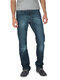
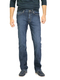
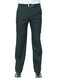
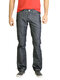
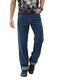
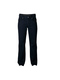
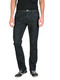
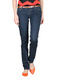
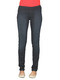
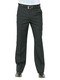
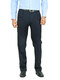
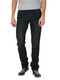
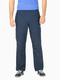
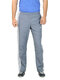

In [25]:
display_result(imgs)


#**Scaling hybrid search**

In [26]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

##**More dense**


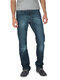
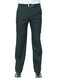
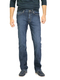
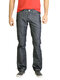
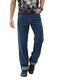
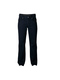

In [27]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)



In [28]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Gini and Jony Boys Solid Black Jeans


##**More sparse**


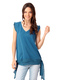
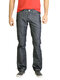
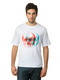
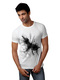
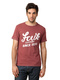
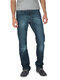

In [29]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [30]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
French Connection Men White T-shirt
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
Peter England Men Party Blue Jeans


##**Dense**


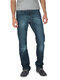
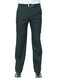
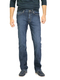
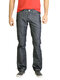
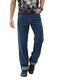
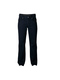

In [31]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)


In [32]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Gini and Jony Boys Solid Black Jeans


#**RRF**

In [ ]:
!pip install langchain_community langchain

In [ ]:
from langchain_community.retrievers import PineconeHybridSearchRetriever

In [ ]:
from langchain.embeddings import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/clip-ViT-B-32")


In [ ]:
query = "dark blue french connection jeans for men"


In [ ]:
retriever =PineconeHybridSearchRetriever(embeddings=embeddings, sparse_encoder=bm25, index=index, alpha=1)

In [33]:
# retriever.invoke("dark blue french connection jeans for men")